In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from transformers import RobertaModel, AdamW
from transformers import RobertaTokenizer
import torch.optim as optim
from transformers import RobertaTokenizer
from torch.utils.data import DataLoader, TensorDataset
import pandas as pd
from torch.utils.data import Dataset, DataLoader
import nltk
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from tqdm import tqdm
from nltk.tokenize import sent_tokenize
import numpy as np
import os

2023-10-14 03:28:31.826250: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
class BertAtt(nn.Module):
    def __init__(self, d_e, h):
        super(BertAtt, self).__init__()
        self.num_heads = h
        self.d_e = d_e
        self.head_dim = d_e // h
        
        self.q = nn.Linear(d_e, d_e)
        self.k = nn.Linear(d_e, d_e)
        self.v = nn.Linear(d_e, d_e)
        
        self.o = nn.Linear(d_e, d_e)
        self.layer_norm = nn.LayerNorm(d_e)
        
        self.dropout = nn.Dropout(dropout_prob)
        
    def forward(self, x):
        Q = self.q(x)
        K = self.k(x)
        V = self.v(x)
        
        Q = Q.view(Q.size(0), -1, self.num_heads, self.head_dim).permute(0, 2, 1, 3)
        K = K.view(K.size(0), -1, self.num_heads, self.head_dim).permute(0, 2, 1, 3)
        V = V.view(V.size(0), -1, self.num_heads, self.head_dim).permute(0, 2, 1, 3)
        
        
        attention_scores = torch.matmul(Q, K.permute(0, 1, 3, 2)) / (self.d_e**0.5)
        attention_probs = F.softmax(attention_scores, dim=-1)
        context = torch.matmul(attention_probs, V)
        
        context = context.permute(0, 2, 1, 3).contiguous()
        context = context.view(context.size(0), -1, self.num_heads*self.head_dim)
        context = self.dropout(context)
        context = self.o(context)
        
        return self.layer_norm(x + context)

class HBN(nn.Module):
    def __init__(self, d_e, h, m, n, y, dropout_prob=0.01, max_sentences=114):
        super(HBN, self).__init__()
        
        # Token-level Roberta encoder
        self.roberta = RobertaModel.from_pretrained("roberta-base")
        
        # Freeze Roberta weights
        for param in self.roberta.parameters():
            param.requires_grad = False
        
        # Sentence-level BERT Encoder
        self.bertatt = BertAtt(d_e, h)
        
        self.ff = nn.Sequential(
            nn.Linear(d_e, n*d_e),
            nn.ReLU(),
            nn.Linear(n*d_e, d_e)
        )
        self.layer_norm = nn.LayerNorm(d_e)
        
        self.multiple_bert_layers = nn.ModuleList([BertAtt(d_e, h) for _ in range(m)])
        
        self.transformation = nn.Linear(d_e, d_e)
        
        self.dropout = nn.Dropout(dropout_prob)
        
        # Prediction Layer
        self.predict = nn.Linear(d_e, y)
        
    def forward(self, input_ids, attention_mask):
#         print(input_ids.shape)
        # Token-level Roberta encoding
        roberta_outputs = self.roberta(input_ids=input_ids, attention_mask=attention_mask)[0]  # [batch_size, seq_length, hidden_size]
        
        # Average pooling to get sentence embeddings
        D = torch.mean(roberta_outputs, dim=1)  # [batch_size, hidden_size]
        
        out = self.bertatt(D)
        out = self.layer_norm(out + F.relu(self.ff(out)))
        
        Z = out
        for layer in self.multiple_bert_layers:
            Z = layer(Z)
        
        S = torch.tanh(torch.mean(Z, dim=1).mm(self.transformation.weight))
        S = self.dropout(S)
        scores = S.mm(self.predict.weight.t())
        
        return scores


In [3]:
# Parameters
d_e = 768  # Assuming you are using 'roberta-base'
h = 1     # Number of attention heads
m = 4      # Number of identical BERT layers
n = 4      # Scaling factor for feed-forward network
y = 2      # Number of classes, set this to your actual number
dropout_prob = 0.01 #dropout probability
num_train_samples = 150
num_epochs = 50
max_length = 128

In [4]:
import os
import pandas as pd
from nltk.tokenize import sent_tokenize

folder1_path = 'sample-text/sample-text/politics/'
folder2_path = 'sample-text/sample-text/business/'

# Fetch file names from both folders
folder1_files = [f for f in os.listdir(folder1_path) if f.endswith('.txt')]
folder2_files = [f for f in os.listdir(folder2_path) if f.endswith('.txt')]

combined_data = []
num_sent=[]

# Read and label files from folder1 and count sentences
for file in folder1_files:
    with open(os.path.join(folder1_path, file), 'r') as f:
        content = f.read()
        num_sentences = len(sent_tokenize(content))
        combined_data.append((content, 0))
        num_sent.append(num_sentences)

# Read and label files from folder2 and count sentences
for file in folder2_files:
    with open(os.path.join(folder2_path, file), 'r') as f:
        content = f.read()
        num_sentences = len(sent_tokenize(content))
        combined_data.append((content, 1))
        num_sent.append(num_sentences)

# Convert combined_data to DataFrame
df = pd.DataFrame(combined_data, columns=['content', 'label'])

# Shuffle the DataFrame
data = df.sample(frac=1).reset_index(drop=True)

# Display the shuffled DataFrame
print(data)

# Find out the maximum number of sentences across all files
max_sentences = max(num_sent)
print(f"\nMaximum number of sentences across all files: {max_sentences}")


                                               content  label
0    High fuel prices hit BA's profits\n\nBritish A...      1
1    What really divides the parties\n\nSo what is ...      0
2    Tutu's Guantanamo release call\n\nArchbishop D...      0
3    Talks aim to avert pension strike\n\nTalks aim...      0
4    Jack Cunningham to stand down\n\nVeteran Labou...      0
..                                                 ...    ...
593  Weak dollar trims Cadbury profits\n\nThe world...      1
594  Business confidence dips in Japan\n\nBusiness ...      1
595  Industrial revival hope for Japan\n\nJapanese ...      1
596  Royal couple watch nation's mood\n\nPrince Cha...      0
597  Campbell: E-mail row 'silly fuss'\n\nEx-No 10 ...      0

[598 rows x 2 columns]

Maximum number of sentences across all files: 248


In [5]:
# len(test_indices),len(train_indices),len(val_indices)

In [6]:
# len(reviews_sentences)

In [7]:
# 2. Split data into train, validation, and test samples
num_train_samples = num_train_samples
num_val_samples = int(0.2 * num_train_samples)
train_data = data.iloc[:num_train_samples]
val_data = data.iloc[num_train_samples:num_train_samples+num_val_samples]
test_data = data.iloc[num_train_samples+num_val_samples:]

# 3. Preprocess and Flatten
def preprocess_and_flatten(dataframe):
    reviews = dataframe['content'].tolist()
    labels = dataframe['label'].tolist()
    reviews = [review.lower() for review in reviews]
    reviews_sentences = [sent_tokenize(review) for review in reviews]
    flattened_reviews = [sentence for review in reviews_sentences for sentence in review]
    flattened_labels = [label for review, label in zip(reviews_sentences, labels) for sentence in review]
    return flattened_reviews, flattened_labels

train_reviews, train_labels = preprocess_and_flatten(train_data)
val_reviews, val_labels = preprocess_and_flatten(val_data)
test_reviews, test_labels = preprocess_and_flatten(test_data)

# 4. Tokenization
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
train_tokens = tokenizer(train_reviews, padding=True, truncation=True, return_tensors="pt", max_length=max_length)
val_tokens = tokenizer(val_reviews, padding=True, truncation=True, return_tensors="pt", max_length=max_length)
test_tokens = tokenizer(test_reviews, padding=True, truncation=True, return_tensors="pt", max_length=max_length)

# 5. Create DataLoader
train_batch_size = 4
val_batch_size = 4
test_batch_size = 4

train_dataset = TensorDataset(train_tokens['input_ids'], train_tokens['attention_mask'], torch.tensor(train_labels))
val_dataset = TensorDataset(val_tokens['input_ids'], val_tokens['attention_mask'], torch.tensor(val_labels))
test_dataset = TensorDataset(test_tokens['input_ids'], test_tokens['attention_mask'], torch.tensor(test_labels))

train_loader = DataLoader(train_dataset, shuffle=True, batch_size=train_batch_size)
val_loader = DataLoader(val_dataset, shuffle=False, batch_size=val_batch_size)
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=test_batch_size)

# Uncomment to test: iterating over the DataLoader
for batch in train_loader:
    input_ids, attention_mask, labels = batch
    print(input_ids.shape, attention_mask.shape, labels.shape)
len(train_loader.dataset),len(val_loader.dataset),len(test_loader.dataset)

torch.Size([4, 115]) torch.Size([4, 115]) torch.Size([4])
torch.Size([4, 115]) torch.Size([4, 115]) torch.Size([4])
torch.Size([4, 115]) torch.Size([4, 115]) torch.Size([4])
torch.Size([4, 115]) torch.Size([4, 115]) torch.Size([4])
torch.Size([4, 115]) torch.Size([4, 115]) torch.Size([4])
torch.Size([4, 115]) torch.Size([4, 115]) torch.Size([4])
torch.Size([4, 115]) torch.Size([4, 115]) torch.Size([4])
torch.Size([4, 115]) torch.Size([4, 115]) torch.Size([4])
torch.Size([4, 115]) torch.Size([4, 115]) torch.Size([4])
torch.Size([4, 115]) torch.Size([4, 115]) torch.Size([4])
torch.Size([4, 115]) torch.Size([4, 115]) torch.Size([4])
torch.Size([4, 115]) torch.Size([4, 115]) torch.Size([4])
torch.Size([4, 115]) torch.Size([4, 115]) torch.Size([4])
torch.Size([4, 115]) torch.Size([4, 115]) torch.Size([4])
torch.Size([4, 115]) torch.Size([4, 115]) torch.Size([4])
torch.Size([4, 115]) torch.Size([4, 115]) torch.Size([4])
torch.Size([4, 115]) torch.Size([4, 115]) torch.Size([4])
torch.Size([4,

(2514, 587, 7667)

In [8]:
# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Initialize the model
model = HBN(d_e, h, m, n, y, dropout_prob).to(device)

# Loss and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=2e-5, eps=1e-8)


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [9]:
def train(model, dataloader, optimizer, criterion, device, epoch):
    model.train()
    total_loss = 0
    for batch in tqdm(dataloader, desc=f"Epoch {epoch + 1}/{num_epochs}"):
        input_ids, attention_mask, labels = batch
        
        input_ids = input_ids.to(device)
        attention_mask = attention_mask.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask)
        loss = criterion(outputs, labels)
        loss.backward()
#         torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        
        total_loss += loss.item()
        
    return total_loss / len(dataloader)

def evaluate(model, dataloader, criterion, device):
    model.eval()
    total_loss = 0
    correct_predictions = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in tqdm(dataloader):
            input_ids, attention_mask, labels = batch

            input_ids = input_ids.to(device)
            attention_mask = attention_mask.to(device)
            labels = labels.to(device)

            outputs = model(input_ids, attention_mask)
            loss = criterion(outputs, labels)
            total_loss += loss.item()

            _, preds = torch.max(outputs, dim=1)
            correct_predictions += torch.sum(preds == labels)
            
            # For AUC
            # Assuming binary classification; you need to get the probabilities for the positive class
            probs = torch.nn.functional.softmax(outputs, dim=1)[:, 1]
            all_preds.extend(probs.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    accuracy = correct_predictions.double() / len(dataloader.dataset)
    auc = roc_auc_score(all_labels, all_preds)
    return total_loss / len(dataloader), accuracy, auc



In [10]:
# Actual Training Loop
train_loss_epoch = []
test_loss_epoch = []
auc = []
for epoch in range(num_epochs):
    train_loss = train(model, train_loader, optimizer, criterion, device, epoch)
    print(f"Train Loss: {train_loss:.4f}")
    val_loss, val_accuracy, val_auc = evaluate(model, val_loader, criterion, device)
    print(f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}, Val AUC: {val_auc:.4f}")
    train_loss_epoch.append(train_loss)
    test_loss_epoch.append(val_loss)
    auc.append(val_auc)

Epoch 1/50: 100%|█████████████████████████████████████████████████████████████████████| 656/656 [01:48<00:00,  6.05it/s]


Train Loss: 0.3883


100%|█████████████████████████████████████████████████████████████████████████████████| 131/131 [00:15<00:00,  8.27it/s]


Val Loss: 0.3658, Val Accuracy: 0.8298, Val AUC: 0.9308


Epoch 2/50: 100%|█████████████████████████████████████████████████████████████████████| 656/656 [01:42<00:00,  6.42it/s]


Train Loss: 0.2564


100%|█████████████████████████████████████████████████████████████████████████████████| 131/131 [00:15<00:00,  8.38it/s]


Val Loss: 0.6379, Val Accuracy: 0.7782, Val AUC: 0.9256


Epoch 3/50: 100%|█████████████████████████████████████████████████████████████████████| 656/656 [01:41<00:00,  6.48it/s]


Train Loss: 0.2326


100%|█████████████████████████████████████████████████████████████████████████████████| 131/131 [00:15<00:00,  8.26it/s]


Val Loss: 0.7116, Val Accuracy: 0.7514, Val AUC: 0.9269


Epoch 4/50: 100%|█████████████████████████████████████████████████████████████████████| 656/656 [01:40<00:00,  6.50it/s]


Train Loss: 0.2122


100%|█████████████████████████████████████████████████████████████████████████████████| 131/131 [00:15<00:00,  8.28it/s]


Val Loss: 0.4319, Val Accuracy: 0.8337, Val AUC: 0.9239


Epoch 5/50: 100%|█████████████████████████████████████████████████████████████████████| 656/656 [01:41<00:00,  6.49it/s]


Train Loss: 0.1996


100%|█████████████████████████████████████████████████████████████████████████████████| 131/131 [00:15<00:00,  8.25it/s]


Val Loss: 0.3907, Val Accuracy: 0.8260, Val AUC: 0.9218


Epoch 6/50: 100%|█████████████████████████████████████████████████████████████████████| 656/656 [01:40<00:00,  6.50it/s]


Train Loss: 0.2054


100%|█████████████████████████████████████████████████████████████████████████████████| 131/131 [00:15<00:00,  8.26it/s]


Val Loss: 0.4106, Val Accuracy: 0.8279, Val AUC: 0.9194


Epoch 7/50: 100%|█████████████████████████████████████████████████████████████████████| 656/656 [01:41<00:00,  6.49it/s]


Train Loss: 0.1937


100%|█████████████████████████████████████████████████████████████████████████████████| 131/131 [00:15<00:00,  8.26it/s]


Val Loss: 0.5505, Val Accuracy: 0.8126, Val AUC: 0.9197


Epoch 8/50: 100%|█████████████████████████████████████████████████████████████████████| 656/656 [01:41<00:00,  6.49it/s]


Train Loss: 0.2060


100%|█████████████████████████████████████████████████████████████████████████████████| 131/131 [00:15<00:00,  8.19it/s]


Val Loss: 0.5013, Val Accuracy: 0.8069, Val AUC: 0.9222


Epoch 9/50: 100%|█████████████████████████████████████████████████████████████████████| 656/656 [01:41<00:00,  6.48it/s]


Train Loss: 0.1924


100%|█████████████████████████████████████████████████████████████████████████████████| 131/131 [00:15<00:00,  8.26it/s]


Val Loss: 0.3721, Val Accuracy: 0.8356, Val AUC: 0.9229


Epoch 10/50: 100%|████████████████████████████████████████████████████████████████████| 656/656 [01:40<00:00,  6.50it/s]


Train Loss: 0.1757


100%|█████████████████████████████████████████████████████████████████████████████████| 131/131 [00:15<00:00,  8.27it/s]


Val Loss: 0.6923, Val Accuracy: 0.7763, Val AUC: 0.9226


Epoch 11/50: 100%|████████████████████████████████████████████████████████████████████| 656/656 [01:41<00:00,  6.49it/s]


Train Loss: 0.1803


100%|█████████████████████████████████████████████████████████████████████████████████| 131/131 [00:15<00:00,  8.28it/s]


Val Loss: 0.4754, Val Accuracy: 0.8184, Val AUC: 0.9218


Epoch 12/50: 100%|████████████████████████████████████████████████████████████████████| 656/656 [01:42<00:00,  6.40it/s]


Train Loss: 0.1739


100%|█████████████████████████████████████████████████████████████████████████████████| 131/131 [00:16<00:00,  8.10it/s]


Val Loss: 0.4874, Val Accuracy: 0.8126, Val AUC: 0.9223


Epoch 13/50: 100%|████████████████████████████████████████████████████████████████████| 656/656 [01:41<00:00,  6.48it/s]


Train Loss: 0.1777


100%|█████████████████████████████████████████████████████████████████████████████████| 131/131 [00:16<00:00,  8.00it/s]


Val Loss: 0.6285, Val Accuracy: 0.8050, Val AUC: 0.9177


Epoch 14/50: 100%|████████████████████████████████████████████████████████████████████| 656/656 [01:45<00:00,  6.23it/s]


Train Loss: 0.1751


100%|█████████████████████████████████████████████████████████████████████████████████| 131/131 [00:16<00:00,  7.91it/s]


Val Loss: 0.3860, Val Accuracy: 0.8394, Val AUC: 0.9154


Epoch 15/50: 100%|████████████████████████████████████████████████████████████████████| 656/656 [01:43<00:00,  6.36it/s]


Train Loss: 0.1718


100%|█████████████████████████████████████████████████████████████████████████████████| 131/131 [00:16<00:00,  7.91it/s]


Val Loss: 0.4465, Val Accuracy: 0.8432, Val AUC: 0.9195


Epoch 16/50: 100%|████████████████████████████████████████████████████████████████████| 656/656 [01:42<00:00,  6.43it/s]


Train Loss: 0.1684


100%|█████████████████████████████████████████████████████████████████████████████████| 131/131 [00:16<00:00,  8.10it/s]


Val Loss: 0.5336, Val Accuracy: 0.8011, Val AUC: 0.9213


Epoch 17/50: 100%|████████████████████████████████████████████████████████████████████| 656/656 [01:42<00:00,  6.42it/s]


Train Loss: 0.1620


100%|█████████████████████████████████████████████████████████████████████████████████| 131/131 [00:16<00:00,  8.11it/s]


Val Loss: 0.6252, Val Accuracy: 0.8011, Val AUC: 0.9192


Epoch 18/50: 100%|████████████████████████████████████████████████████████████████████| 656/656 [01:42<00:00,  6.42it/s]


Train Loss: 0.1702


100%|█████████████████████████████████████████████████████████████████████████████████| 131/131 [00:16<00:00,  8.06it/s]


Val Loss: 0.4107, Val Accuracy: 0.8260, Val AUC: 0.9214


Epoch 19/50: 100%|████████████████████████████████████████████████████████████████████| 656/656 [01:41<00:00,  6.46it/s]


Train Loss: 0.1576


100%|█████████████████████████████████████████████████████████████████████████████████| 131/131 [00:16<00:00,  8.10it/s]


Val Loss: 0.4094, Val Accuracy: 0.8203, Val AUC: 0.9189


Epoch 20/50: 100%|████████████████████████████████████████████████████████████████████| 656/656 [01:41<00:00,  6.43it/s]


Train Loss: 0.1512


100%|█████████████████████████████████████████████████████████████████████████████████| 131/131 [00:16<00:00,  8.09it/s]


Val Loss: 0.5157, Val Accuracy: 0.8107, Val AUC: 0.9190


Epoch 21/50: 100%|████████████████████████████████████████████████████████████████████| 656/656 [01:42<00:00,  6.43it/s]


Train Loss: 0.1639


100%|█████████████████████████████████████████████████████████████████████████████████| 131/131 [00:16<00:00,  8.09it/s]


Val Loss: 0.3849, Val Accuracy: 0.8413, Val AUC: 0.9185


Epoch 22/50: 100%|████████████████████████████████████████████████████████████████████| 656/656 [01:48<00:00,  6.07it/s]


Train Loss: 0.1556


100%|█████████████████████████████████████████████████████████████████████████████████| 131/131 [00:21<00:00,  6.00it/s]


Val Loss: 0.4172, Val Accuracy: 0.8260, Val AUC: 0.9177


Epoch 23/50: 100%|████████████████████████████████████████████████████████████████████| 656/656 [02:20<00:00,  4.67it/s]


Train Loss: 0.1478


100%|█████████████████████████████████████████████████████████████████████████████████| 131/131 [00:24<00:00,  5.44it/s]


Val Loss: 0.5091, Val Accuracy: 0.8145, Val AUC: 0.9171


Epoch 24/50: 100%|████████████████████████████████████████████████████████████████████| 656/656 [01:56<00:00,  5.62it/s]


Train Loss: 0.1500


100%|█████████████████████████████████████████████████████████████████████████████████| 131/131 [00:16<00:00,  8.16it/s]


Val Loss: 0.4738, Val Accuracy: 0.8337, Val AUC: 0.9184


Epoch 25/50: 100%|████████████████████████████████████████████████████████████████████| 656/656 [01:41<00:00,  6.49it/s]


Train Loss: 0.1439


100%|█████████████████████████████████████████████████████████████████████████████████| 131/131 [00:22<00:00,  5.95it/s]


Val Loss: 0.6240, Val Accuracy: 0.8088, Val AUC: 0.9204


Epoch 26/50: 100%|████████████████████████████████████████████████████████████████████| 656/656 [02:30<00:00,  4.37it/s]


Train Loss: 0.1422


100%|█████████████████████████████████████████████████████████████████████████████████| 131/131 [00:25<00:00,  5.18it/s]


Val Loss: 0.5681, Val Accuracy: 0.8337, Val AUC: 0.9205


Epoch 27/50: 100%|████████████████████████████████████████████████████████████████████| 656/656 [02:16<00:00,  4.80it/s]


Train Loss: 0.1418


100%|█████████████████████████████████████████████████████████████████████████████████| 131/131 [00:16<00:00,  8.00it/s]


Val Loss: 0.5075, Val Accuracy: 0.8069, Val AUC: 0.9211


Epoch 28/50: 100%|████████████████████████████████████████████████████████████████████| 656/656 [01:42<00:00,  6.40it/s]


Train Loss: 0.1462


100%|█████████████████████████████████████████████████████████████████████████████████| 131/131 [00:17<00:00,  7.65it/s]


Val Loss: 0.4613, Val Accuracy: 0.8184, Val AUC: 0.9175


Epoch 29/50: 100%|████████████████████████████████████████████████████████████████████| 656/656 [01:42<00:00,  6.41it/s]


Train Loss: 0.1289


100%|█████████████████████████████████████████████████████████████████████████████████| 131/131 [00:23<00:00,  5.62it/s]


Val Loss: 0.4782, Val Accuracy: 0.8164, Val AUC: 0.9186


Epoch 30/50: 100%|████████████████████████████████████████████████████████████████████| 656/656 [01:47<00:00,  6.11it/s]


Train Loss: 0.1348


100%|█████████████████████████████████████████████████████████████████████████████████| 131/131 [00:16<00:00,  7.93it/s]


Val Loss: 0.4877, Val Accuracy: 0.8337, Val AUC: 0.9200


Epoch 31/50: 100%|████████████████████████████████████████████████████████████████████| 656/656 [01:42<00:00,  6.40it/s]


Train Loss: 0.1386


100%|█████████████████████████████████████████████████████████████████████████████████| 131/131 [00:16<00:00,  8.07it/s]


Val Loss: 0.5636, Val Accuracy: 0.8184, Val AUC: 0.9147


Epoch 32/50: 100%|████████████████████████████████████████████████████████████████████| 656/656 [01:41<00:00,  6.45it/s]


Train Loss: 0.1320


100%|█████████████████████████████████████████████████████████████████████████████████| 131/131 [00:16<00:00,  8.02it/s]


Val Loss: 0.4569, Val Accuracy: 0.8203, Val AUC: 0.9172


Epoch 33/50: 100%|████████████████████████████████████████████████████████████████████| 656/656 [02:01<00:00,  5.40it/s]


Train Loss: 0.1335


100%|█████████████████████████████████████████████████████████████████████████████████| 131/131 [00:20<00:00,  6.42it/s]


Val Loss: 0.4817, Val Accuracy: 0.8203, Val AUC: 0.9200


Epoch 34/50: 100%|████████████████████████████████████████████████████████████████████| 656/656 [02:12<00:00,  4.95it/s]


Train Loss: 0.1263


100%|█████████████████████████████████████████████████████████████████████████████████| 131/131 [00:23<00:00,  5.52it/s]


Val Loss: 0.4632, Val Accuracy: 0.8317, Val AUC: 0.9167


Epoch 35/50: 100%|████████████████████████████████████████████████████████████████████| 656/656 [02:14<00:00,  4.89it/s]


Train Loss: 0.1329


100%|█████████████████████████████████████████████████████████████████████████████████| 131/131 [00:16<00:00,  8.11it/s]


Val Loss: 0.5746, Val Accuracy: 0.8031, Val AUC: 0.9213


Epoch 36/50: 100%|████████████████████████████████████████████████████████████████████| 656/656 [01:59<00:00,  5.47it/s]


Train Loss: 0.1314


100%|█████████████████████████████████████████████████████████████████████████████████| 131/131 [00:24<00:00,  5.32it/s]


Val Loss: 0.7176, Val Accuracy: 0.8069, Val AUC: 0.9197


Epoch 37/50: 100%|████████████████████████████████████████████████████████████████████| 656/656 [02:12<00:00,  4.93it/s]


Train Loss: 0.1248


100%|█████████████████████████████████████████████████████████████████████████████████| 131/131 [00:16<00:00,  8.08it/s]


Val Loss: 0.4703, Val Accuracy: 0.8260, Val AUC: 0.9215


Epoch 38/50: 100%|████████████████████████████████████████████████████████████████████| 656/656 [02:02<00:00,  5.35it/s]


Train Loss: 0.1189


100%|█████████████████████████████████████████████████████████████████████████████████| 131/131 [00:24<00:00,  5.29it/s]


Val Loss: 0.4542, Val Accuracy: 0.8184, Val AUC: 0.9207


Epoch 39/50: 100%|████████████████████████████████████████████████████████████████████| 656/656 [02:23<00:00,  4.57it/s]


Train Loss: 0.1315


100%|█████████████████████████████████████████████████████████████████████████████████| 131/131 [00:19<00:00,  6.74it/s]


Val Loss: 0.5444, Val Accuracy: 0.8050, Val AUC: 0.9208


Epoch 40/50: 100%|████████████████████████████████████████████████████████████████████| 656/656 [01:48<00:00,  6.06it/s]


Train Loss: 0.1252


100%|█████████████████████████████████████████████████████████████████████████████████| 131/131 [00:16<00:00,  7.91it/s]


Val Loss: 0.4986, Val Accuracy: 0.8126, Val AUC: 0.9212


Epoch 41/50: 100%|████████████████████████████████████████████████████████████████████| 656/656 [01:43<00:00,  6.33it/s]


Train Loss: 0.1207


100%|█████████████████████████████████████████████████████████████████████████████████| 131/131 [00:25<00:00,  5.17it/s]


Val Loss: 0.5499, Val Accuracy: 0.8279, Val AUC: 0.9207


Epoch 42/50: 100%|████████████████████████████████████████████████████████████████████| 656/656 [01:51<00:00,  5.91it/s]


Train Loss: 0.1219


100%|█████████████████████████████████████████████████████████████████████████████████| 131/131 [00:17<00:00,  7.61it/s]


Val Loss: 0.4678, Val Accuracy: 0.8337, Val AUC: 0.9225


Epoch 43/50: 100%|████████████████████████████████████████████████████████████████████| 656/656 [01:46<00:00,  6.16it/s]


Train Loss: 0.1294


100%|█████████████████████████████████████████████████████████████████████████████████| 131/131 [00:17<00:00,  7.39it/s]


Val Loss: 0.4691, Val Accuracy: 0.8317, Val AUC: 0.9219


Epoch 44/50: 100%|████████████████████████████████████████████████████████████████████| 656/656 [01:43<00:00,  6.36it/s]


Train Loss: 0.1234


100%|█████████████████████████████████████████████████████████████████████████████████| 131/131 [00:16<00:00,  7.93it/s]


Val Loss: 0.4525, Val Accuracy: 0.8337, Val AUC: 0.9188


Epoch 45/50: 100%|████████████████████████████████████████████████████████████████████| 656/656 [01:41<00:00,  6.45it/s]


Train Loss: 0.1195


100%|█████████████████████████████████████████████████████████████████████████████████| 131/131 [00:16<00:00,  8.02it/s]


Val Loss: 0.7532, Val Accuracy: 0.8145, Val AUC: 0.9180


Epoch 46/50: 100%|████████████████████████████████████████████████████████████████████| 656/656 [01:41<00:00,  6.46it/s]


Train Loss: 0.1313


100%|█████████████████████████████████████████████████████████████████████████████████| 131/131 [00:16<00:00,  8.11it/s]


Val Loss: 0.5641, Val Accuracy: 0.7954, Val AUC: 0.9230


Epoch 47/50: 100%|████████████████████████████████████████████████████████████████████| 656/656 [01:41<00:00,  6.44it/s]


Train Loss: 0.1117


100%|█████████████████████████████████████████████████████████████████████████████████| 131/131 [00:16<00:00,  8.00it/s]


Val Loss: 0.5328, Val Accuracy: 0.8184, Val AUC: 0.9190


Epoch 48/50: 100%|████████████████████████████████████████████████████████████████████| 656/656 [01:41<00:00,  6.48it/s]


Train Loss: 0.1113


100%|█████████████████████████████████████████████████████████████████████████████████| 131/131 [00:16<00:00,  8.12it/s]


Val Loss: 0.5243, Val Accuracy: 0.8145, Val AUC: 0.9141


Epoch 49/50: 100%|████████████████████████████████████████████████████████████████████| 656/656 [01:41<00:00,  6.47it/s]


Train Loss: 0.1133


100%|█████████████████████████████████████████████████████████████████████████████████| 131/131 [00:16<00:00,  8.06it/s]


Val Loss: 0.5911, Val Accuracy: 0.8184, Val AUC: 0.9201


Epoch 50/50: 100%|████████████████████████████████████████████████████████████████████| 656/656 [01:41<00:00,  6.44it/s]


Train Loss: 0.1095


100%|█████████████████████████████████████████████████████████████████████████████████| 131/131 [00:16<00:00,  8.01it/s]

Val Loss: 0.6208, Val Accuracy: 0.8164, Val AUC: 0.9154


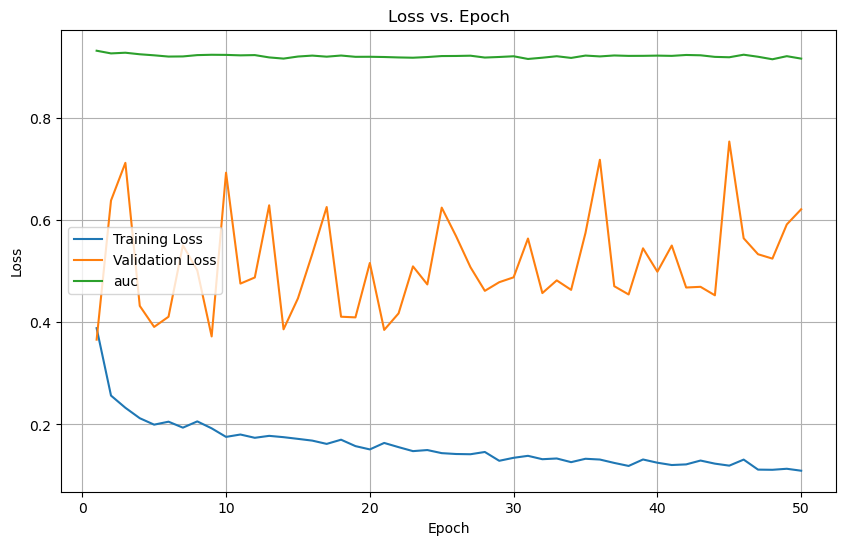

In [11]:
import matplotlib.pyplot as plt

# Plot Loss vs. Epoch
epochs = range(1, num_epochs + 1)

plt.figure(figsize=(10, 6))
plt.plot(epochs, train_loss_epoch, label='Training Loss')
plt.plot(epochs, test_loss_epoch, label='Validation Loss')
plt.plot(epochs, auc, label='auc')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss vs. Epoch')
plt.legend()
plt.grid(True)
plt.show()


In [12]:
val_loss, val_accuracy, val_auc = evaluate(model, test_loader, criterion, device)
print(f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}, Val AUC: {val_auc:.4f}")

100%|███████████████████████████████████████████████████████████████████████████████| 1906/1906 [04:01<00:00,  7.91it/s]

Val Loss: 0.3824, Val Accuracy: 0.8881, Val AUC: 0.9551


In [13]:
len(test_loader.dataset)

7624